# Manipulating fMRI data and computing a connectome

## Loading the data

In [1]:
from nilearn import datasets, plotting
import numpy as np

data_dir = '/Users/hycheng/Desktop/MS/113-2/BH/final_project/refDLdata' # change this variable with the path where you want nilearn to download
                # the data, if you leave None, the default will be '~/nilearn_data'
    
# Loading the functional datasets
# data = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_dir)
# data = 

# you can use the .keys() method to check what's in the dataset
# data.keys()

In [3]:
# We can check the description of the dataset to know what we're dealing with 
# print(data.description)

In [5]:
# data.func contains the paths to the Nifti files (the files containing fMRI data)
# fmri_filepath = data.func[0]
fmri_filepath = '/Users/hycheng/Desktop/MS/113-2/BH/final_project/ses-00/sub-02/func/F1/mswaF1_ep2d_moco_4mm_240_1-6_20230612155952_8.nii'
print(fmri_filepath)

/Users/hycheng/Desktop/MS/113-2/BH/final_project/ses-00/sub-02/func/F1/mswaF1_ep2d_moco_4mm_240_1-6_20230612155952_8.nii


In [7]:
# We can load a Nifti file with the nibabel library
import nibabel as nib

fmri_img = nib.load(fmri_filepath)
print(fmri_img.affine)

[[   2.    0.    0.  -78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -70.]
 [   0.    0.    0.    1.]]


So this is a `Nifti1Image` object which contains 3 things :
* some data of shape (50, 59, 50, 168)
* an affine array that defines the spatial orientation and scale of the data
* a header, containing more information about the data format

Note that the data is a 4D array. The last dimension is the time, so we have 168 volumes, and from the 5th value of the pixdim array in the header we can see that the t_r is 1s, so we have a file that represents 168s of scanning. 

For each time point we have a 3D array that contains the voxels. But not all these voxels correspond to the brain.

In [10]:
# let's get the data array 
fmri_data = fmri_img.get_fdata()
fmri_data.shape

(79, 95, 79, 188)

We can choose a voxel (for example the one with coordinates 25, 30, 25) and plot its time series :

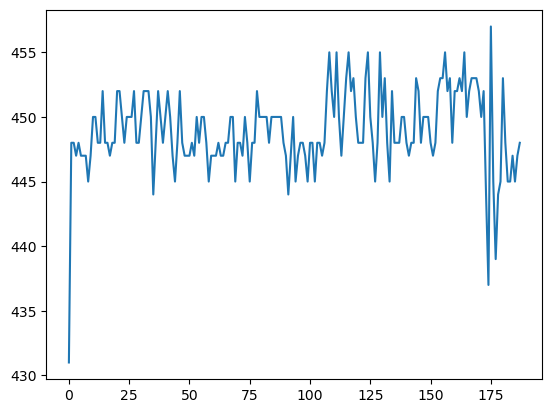

In [13]:
import matplotlib.pyplot as plt

plt.plot(fmri_data[25,30,25])

We can also plot a slice of our brain for a time point as an image, for example a transversal slice for the first time point and z=25 : 

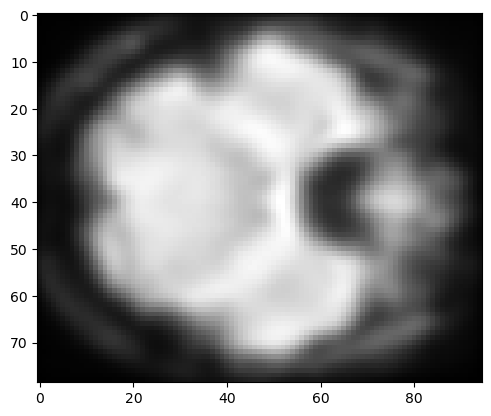

In [16]:
plt.imshow(fmri_data[:,:,25,70], cmap='gray')

Here all the black pixels in our image are voxels present in our `fmri_data` array but not containing any brain. Thus we want to exclude all these empty voxels just to keep the ones containing brain data. To do that we're gonna use a **masker**. 

## Masking the data

The masker not only removes the background voxels, but it can also regress out the confounds if you provide them.

In short, the confounds are external sources of signal you want to remove, such as the movement of the head. Regressing out the confounds means removing the part of the signal correlated to the sources of noise. For example we can remove the part of the signal that correlates with the head motion because we consider this part of signal to be only artefacts caused by the movements and not relevant for brain activity. 

Confounds handling is in reality more complicated than that, if you want to learn more you can check the [fMRIprep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

In [19]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker(target_affine=fmri_img.affine)
masked_data = masker.fit_transform(fmri_filepath, confounds=None)
masked_data.shape

[NiftiMasker.wrapped] Resampling images

/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py:312: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)


(188, 592877)

Now you see that our array has a different shape, we have our time dimension first with still 168 time points, but for each time point, instead of a 3D volume, we have a 1D array. 

Also note that we kept 32,504 voxels, when whe had a total of 50*59*50 = 147,500, so we got rid of a lot of empty voxels. That is good, but the downside is that we lost the spatial information of where these voxels are in the brain. But don't worry because the masker remembers it. If we want to recover this information and turn back our 1D arrays into 3D spatial ones we can uste the `makser.inverse_transform` method.

For example if we want to threshold our fMRI data by the mean and then plot ther result we can do it this way :

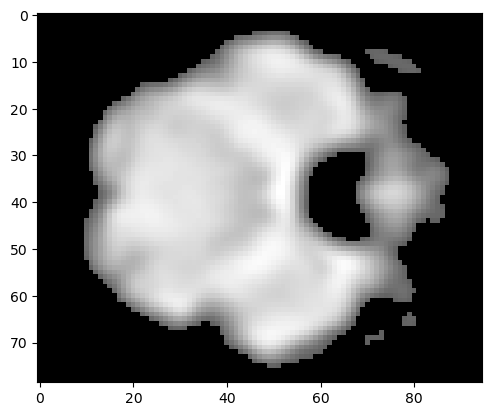

In [21]:
thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

thresholded_img = masker.inverse_transform(thresholded_masked_data)

plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')

**NOTE**: In this example we instantiated a `NiftiMasker` without providing any argument, 
however depending on the data used, we might want to use specific strategies to remove the
background voxels, and we can ask the masker to do some complementrary processing such as 
standardizing the data, deterending it or resampleing it. In real-life use cases you should carefully 
choose the arguments to provide to the `NiftiMasker`. These arguments are explained in 
the [nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html).

## Using an atlas

Having removed the empty voxels is great, and we could directly compute a connectome on the masked data,
but it would create a 32,504 by 32,504 matrix, which would be a bit hard to analyse.

An easier way to manipulate the data would be to use an atlas, that defines region of interest (ROIs). We could create our own atlas by clustering the voxels, but hopefully nilearn provides ready-made atlases, let's load one.

In [26]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

[get_dataset_dir] Dataset found in /Users/hycheng/Desktop/MS/113-2/BH/final_project/refDLdata/msdl_atlas

We now have the path to the Nifti file containing the ROIs info in `atlas_filepath` and the names of the ROIs in `labels`.

To apply the atlas on our data, we can once again use a masker, bu this time a `NiftiMapsMasker`.

In [29]:
from nilearn.input_data import NiftiMapsMasker

atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True,
                               resampling_target="data")

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=None)# fmri_img.confounds
data_in_atlas.shape

(188, 39)

We see that now we only have 39 values per time point, so we have 39 ROIs. This is more appropriate to compute a connectivity matrix.

We can plot the time series in a ROI (for example the 5th one) :

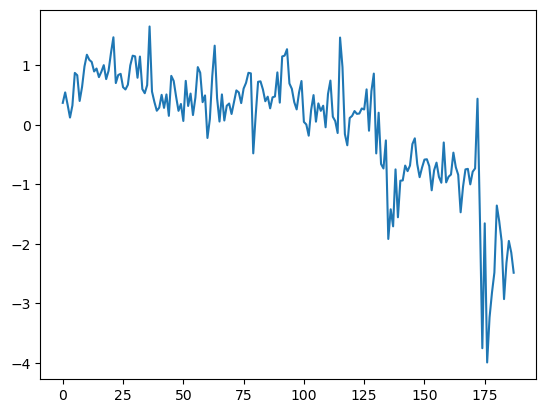

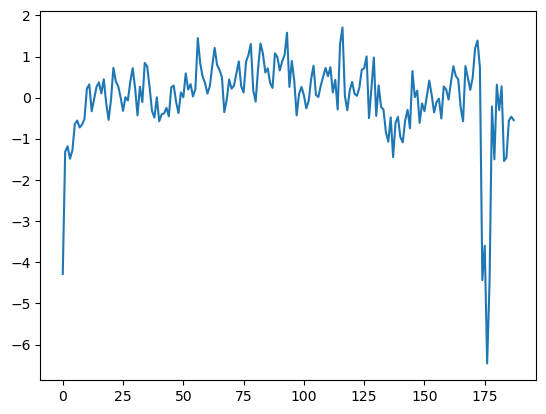

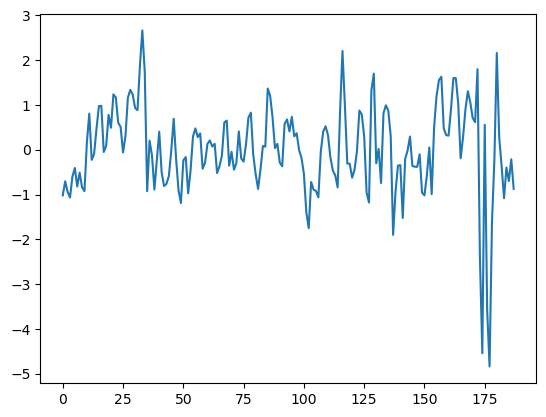

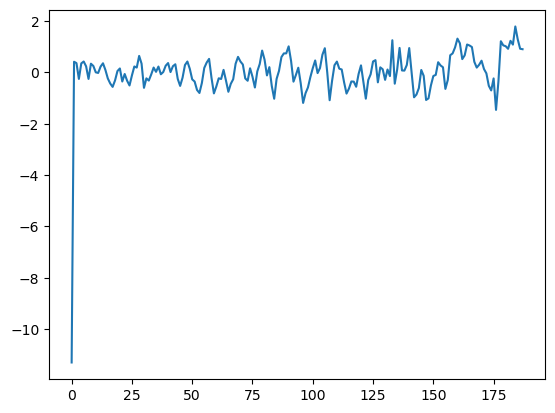

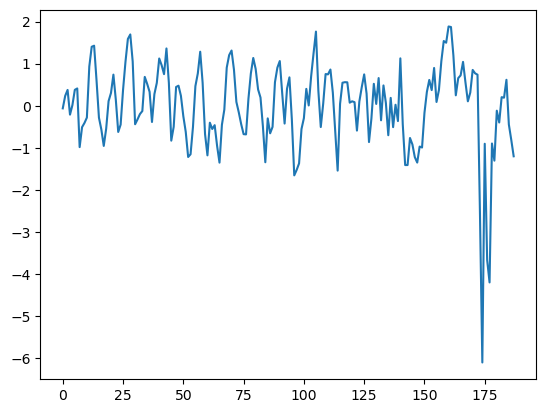

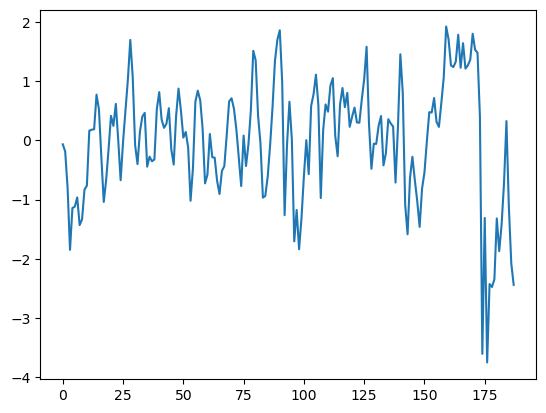

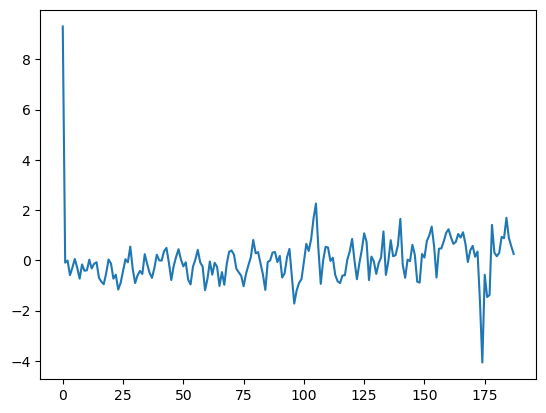

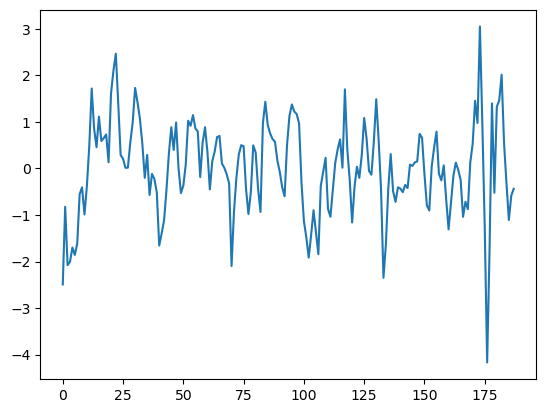

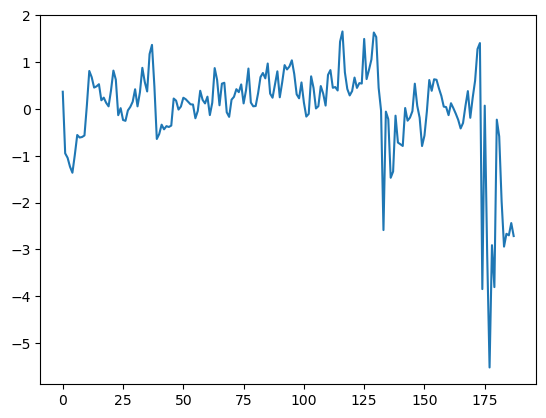

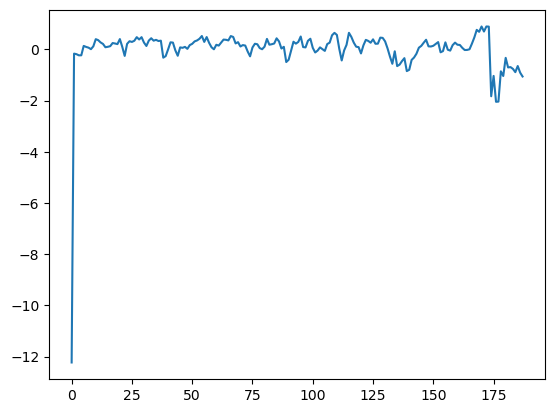

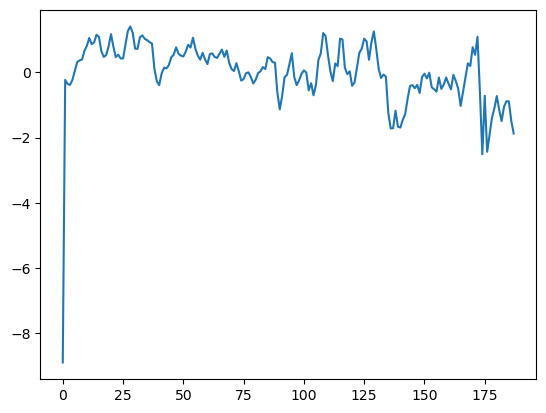

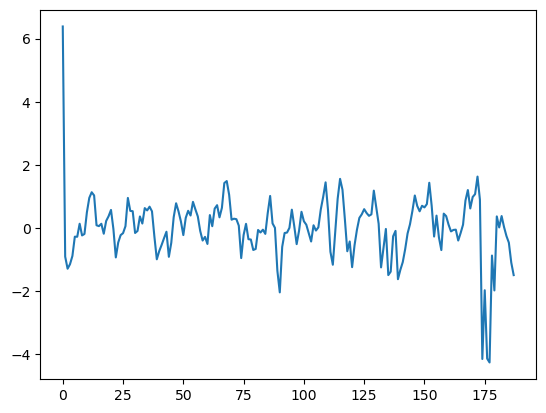

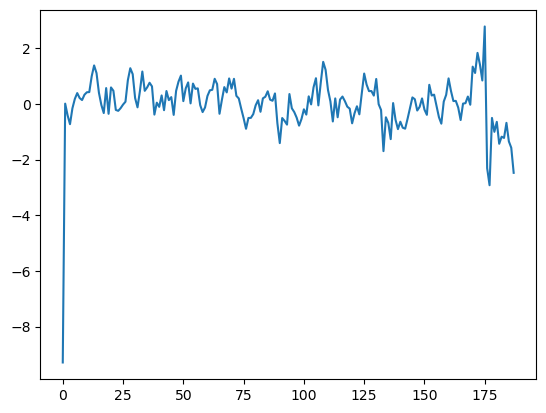

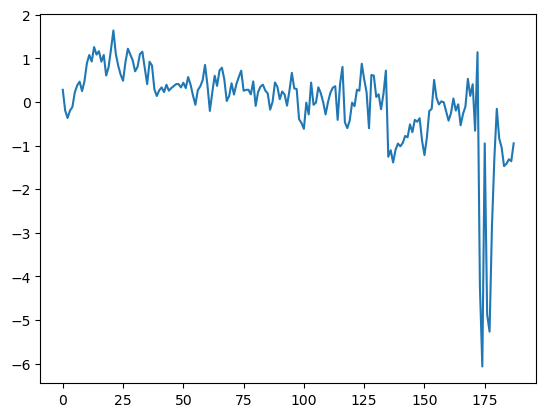

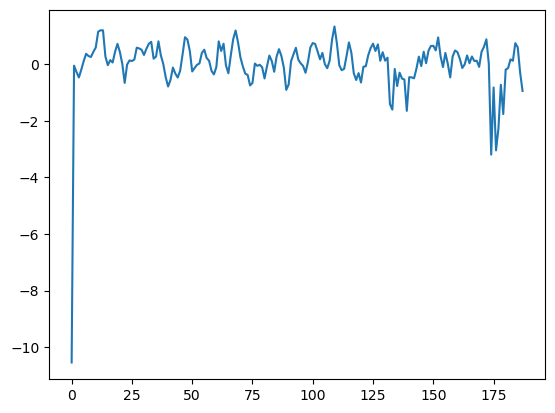

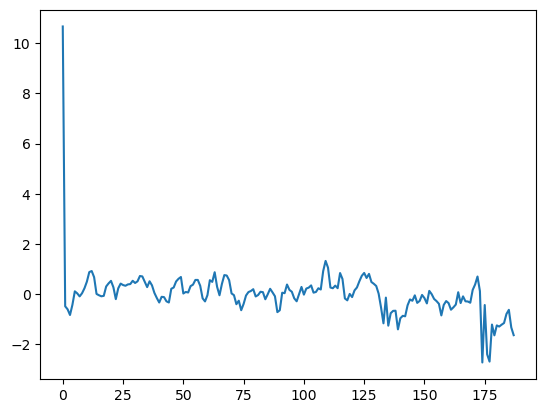

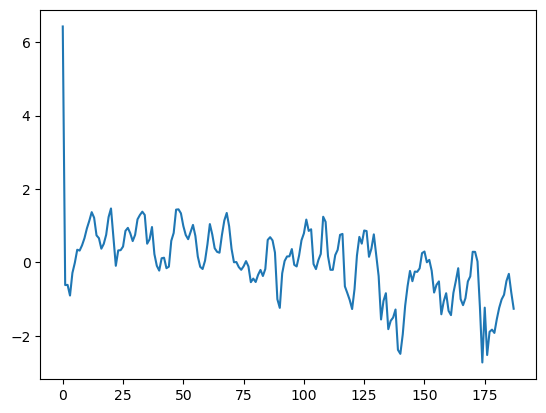

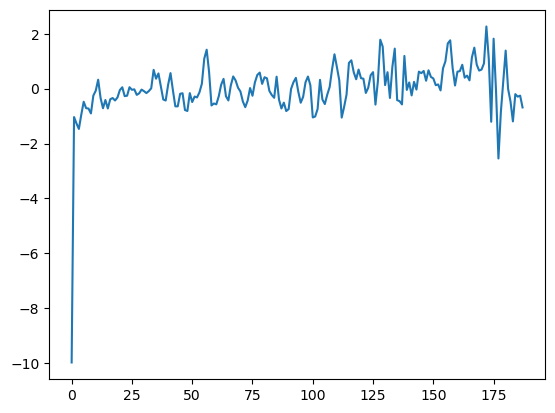

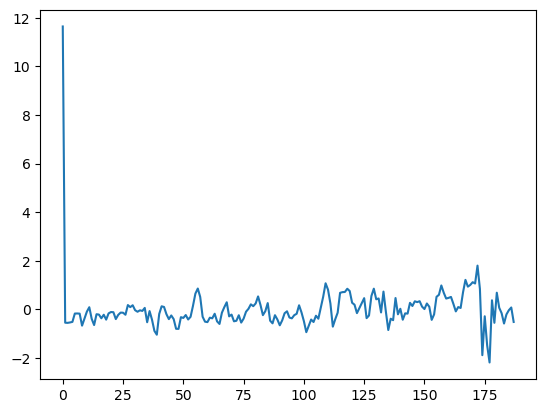

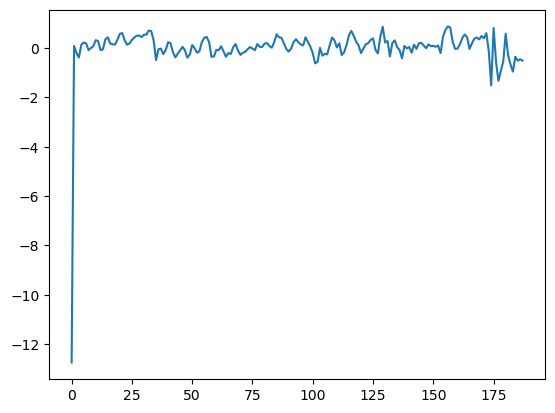

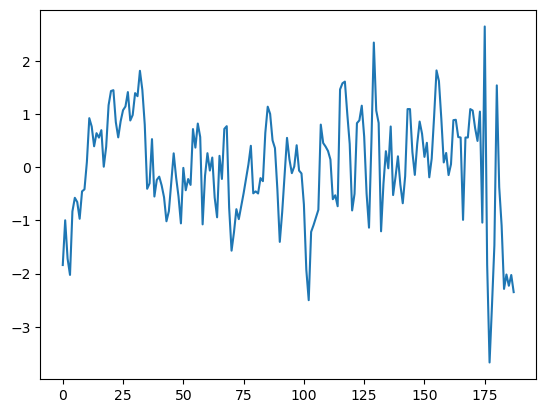

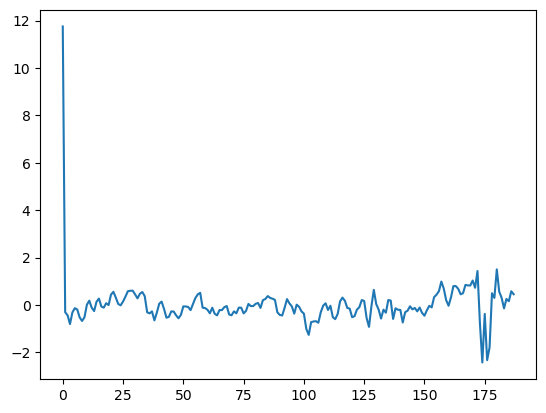

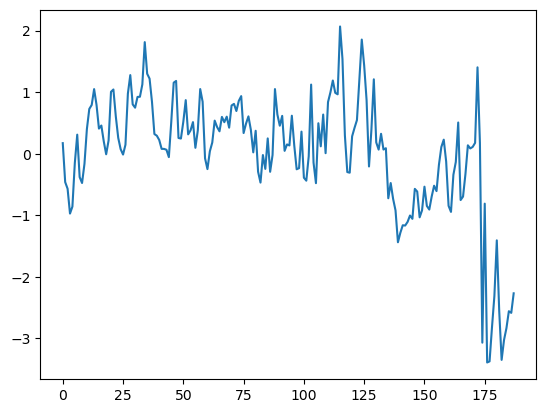

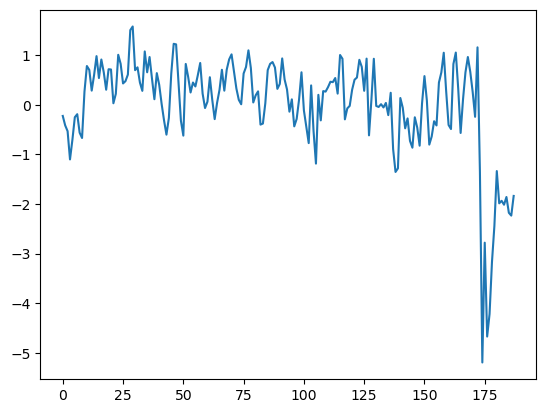

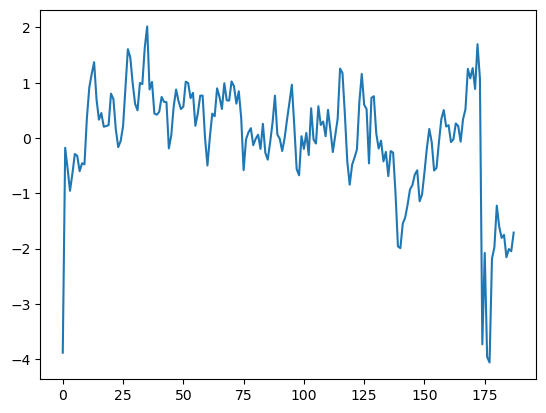

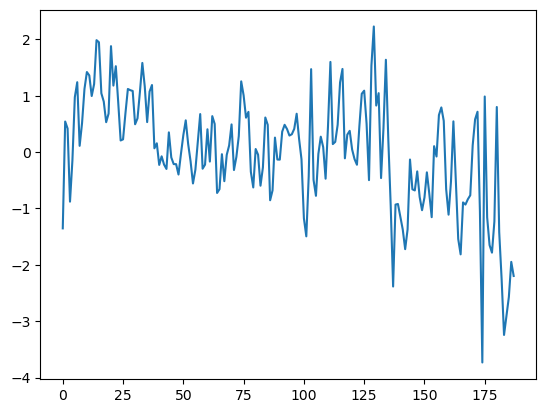

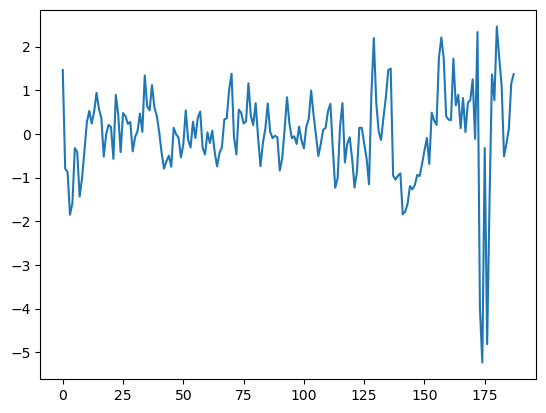

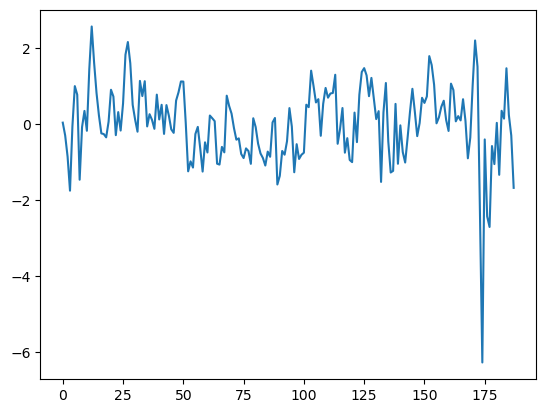

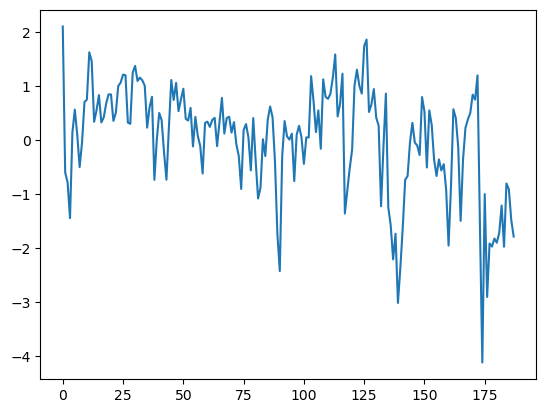

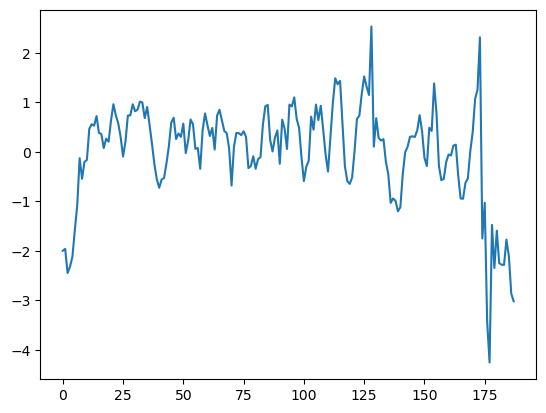

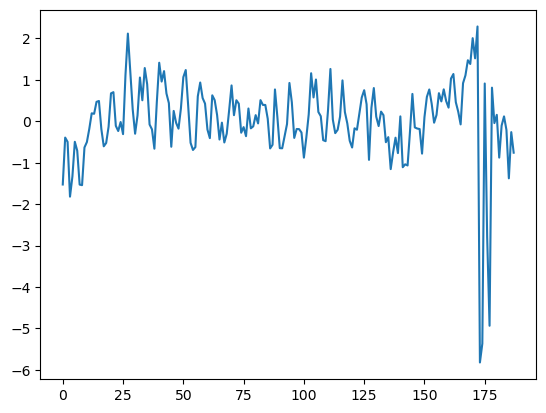

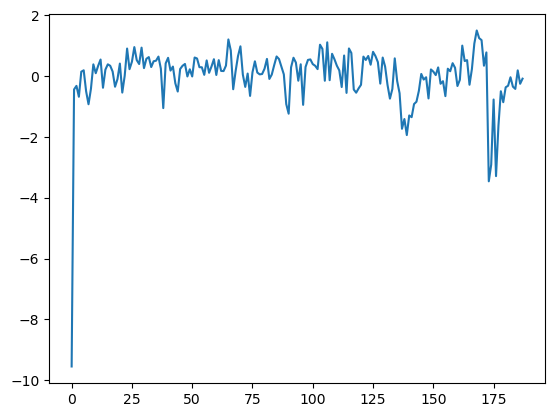

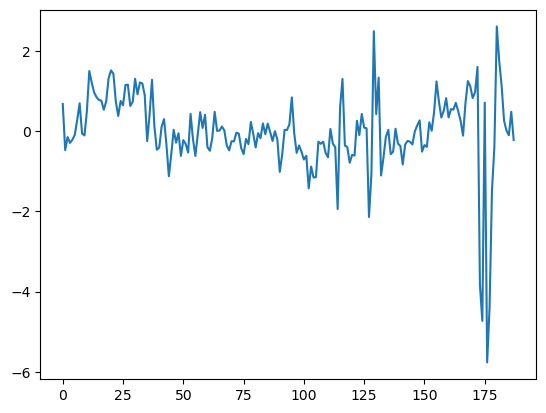

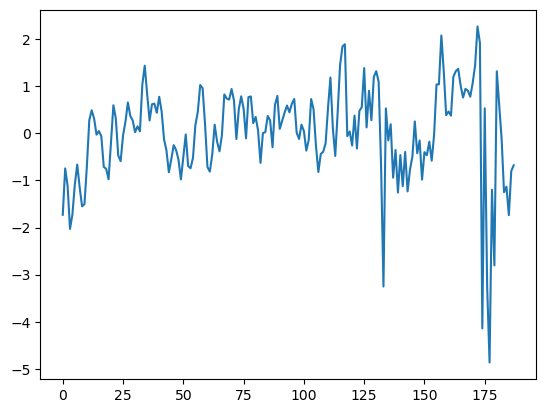

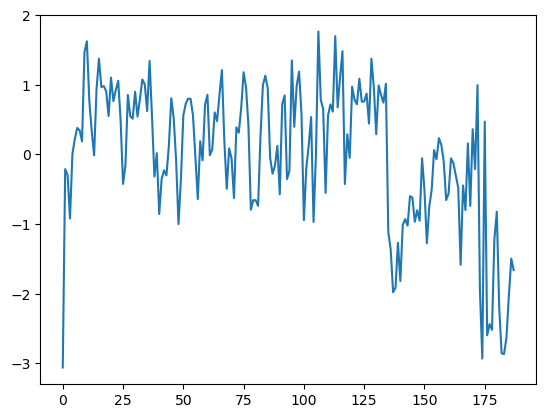

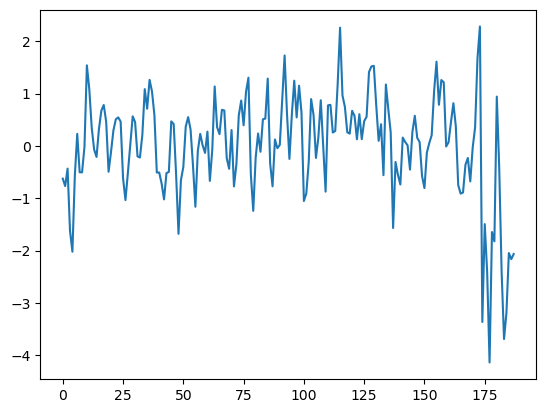

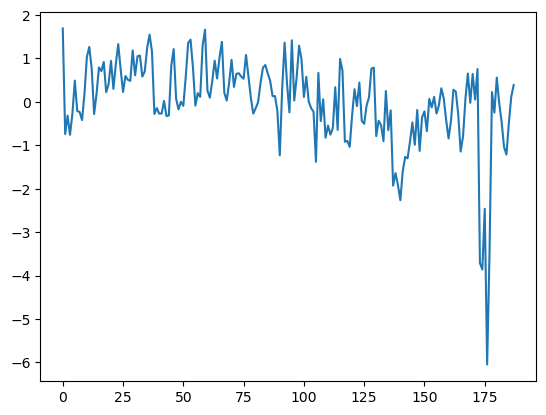

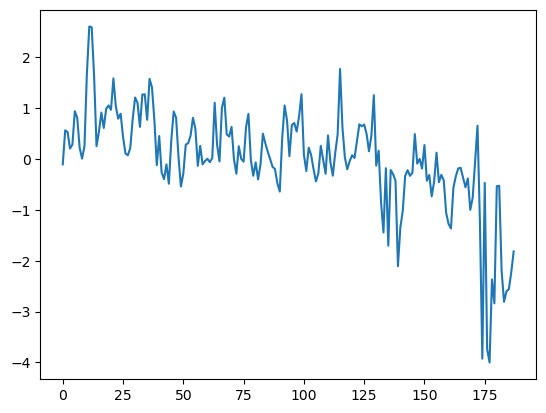

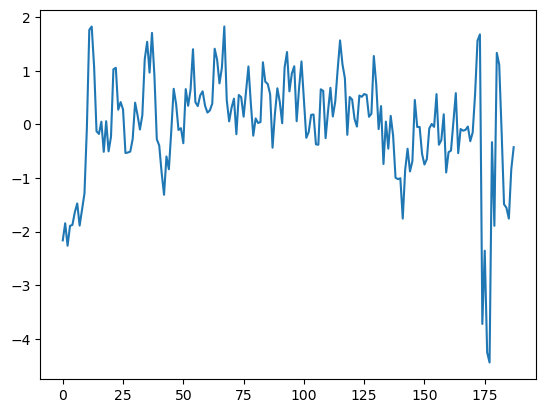

In [31]:
for i in range(39):
    plt.plot(data_in_atlas[:,i])
    plt.show()

**Note**: Depending on the type of atlas you use, you might have to use different kinds of masker. Here we have probabilistic overlapping regions, so we use a `NiftiMapsMasker`, but if we had non-overlapping regions, we would use a `NiftiLabelsMasker`.

## Connectome

Let's compute and plot a correlation matrix !

In [33]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)
plt.show()

NameError: name 'nilearn' is not defined

## Plotting

Earlier we simply plotted a slice of our brain with matplotlib. It works and it is a fine way to check your data array. However for more complex or fancy plots, nilearn comes with a lot of handy tools in its `nilearn.plotting` module. Here are a few examples.

* To view a 3D NiftiImage object, the `view_img` functions makes it easy to interactively go through the slices.

/var/folders/9m/172vd1l95lzfrht66cqtl0lm0000gn/T/ipykernel_89971/1984845907.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  fmri_img_mean = mean_img(fmri_img)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



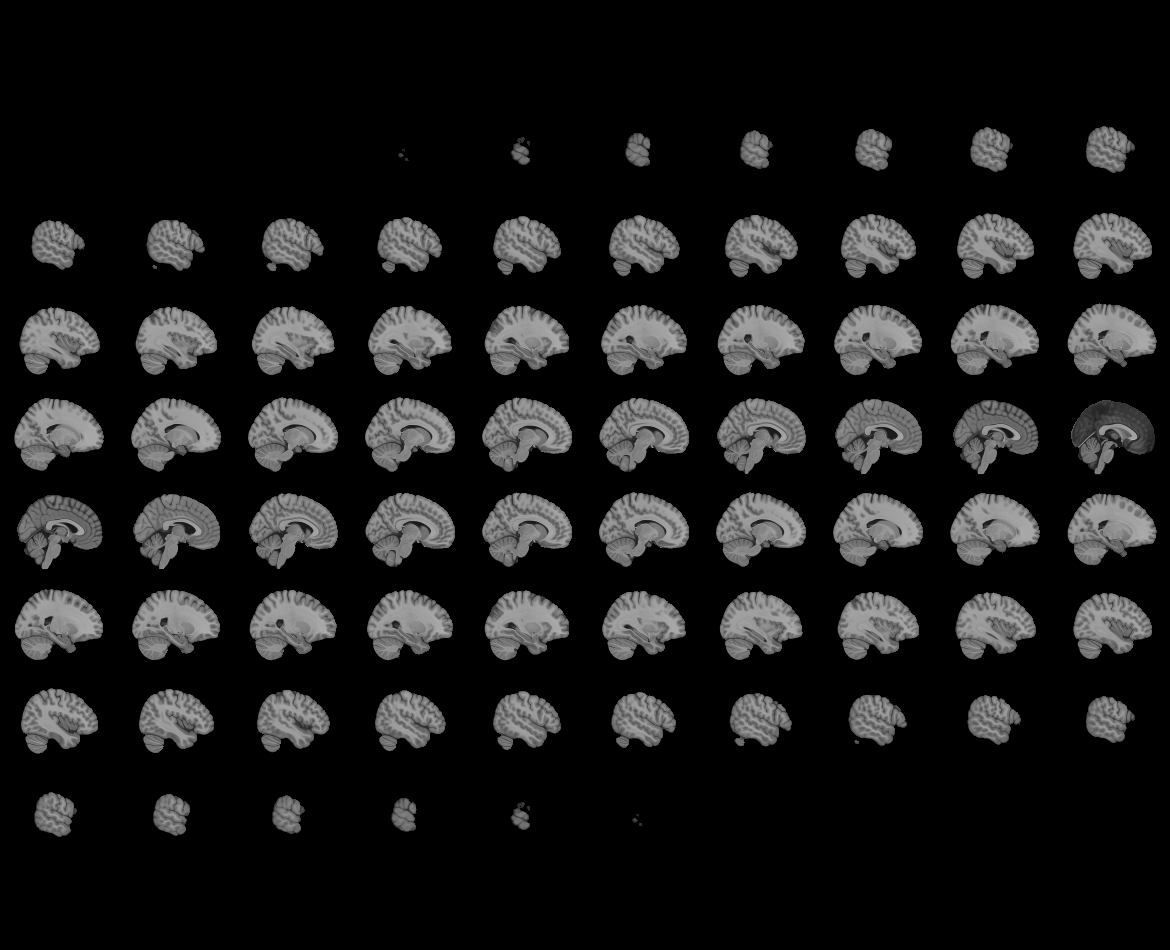
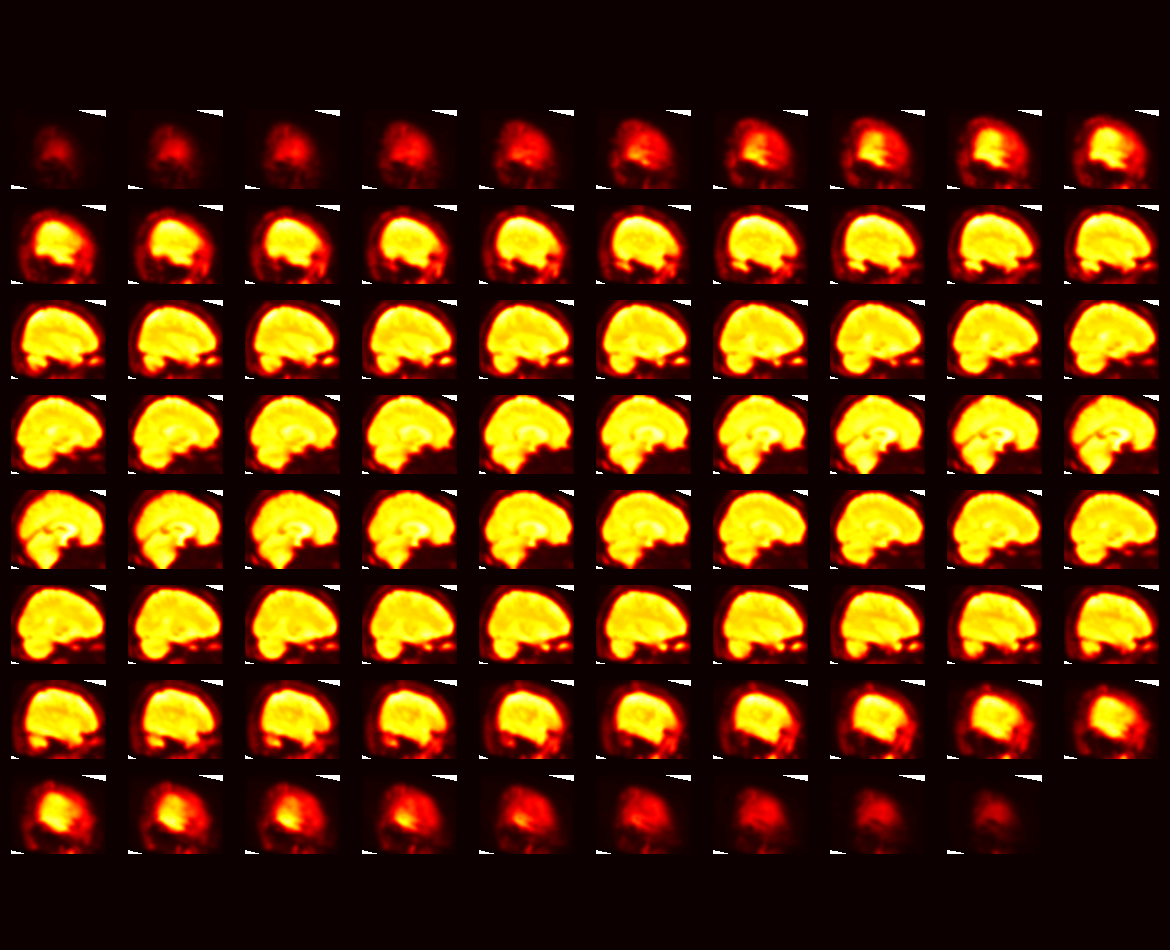

In [51]:
# Since our fmri_img is a 4D NiftiImage, we need to generate a 3D one.
# One way of doing that is averaging our volumes on the time axis 
# with the mean_img function.
from nilearn.image.image import mean_img

fmri_img_mean = mean_img(fmri_img)
plotting.view_img(fmri_img_mean)

* To display the graph corresponding to a connectome, you can use `plot_connectome`.

In [53]:
coords = atlas_dataset.region_coords

# We threshold to keep only the 10% of edges with the highest value
# because the graph is very dense
nilearn.plotting.plot_connectome(correlation_matrix, coords,
                edge_threshold="90%", colorbar=True)


NameError: name 'correlation_matrix' is not defined

To discover more ways of generating super cool visuals of brains, check the [nilearn plotting documentation](https://nilearn.github.io/plotting/index.html).

# Exercises

## 1. Of the importance of confounds

* Generate a correlation matrix with the same data, but this time without using the confounds when masking.

How does that impact the correlation matrix ?
Why do you think it affects the matrix this way ?

* Plot the obtained connectome in 3D using `nilearn.plotting.view_connectome` (check [the doc](https://nilearn.github.io/modules/generated/nilearn.plotting.view_connectome.html) to know how to use it).

## 2. Visualizing the atlas and a specific time point

* Use `view_img` to visualize the 5th ROI of the atlas. (Hint: use the atlas masker to inverse transform an array with 1 at the index 4 and 0 every where else.)

* Use `plotting.plot_prob_atlas` to show all the ROIs with filled contours. (Hint: check the nilearn documentation to see how to use `plotting.plot_prob_atlas`).
* Earlier we used `view_img` to plot the mean volume of our `fmri_img` data because `view_img` doesn't accept 4D images but only 3D ones. Find a way to generate a 3D Nifti image with the 84th time point in `fmri_img` and plot it with `view_img`.

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



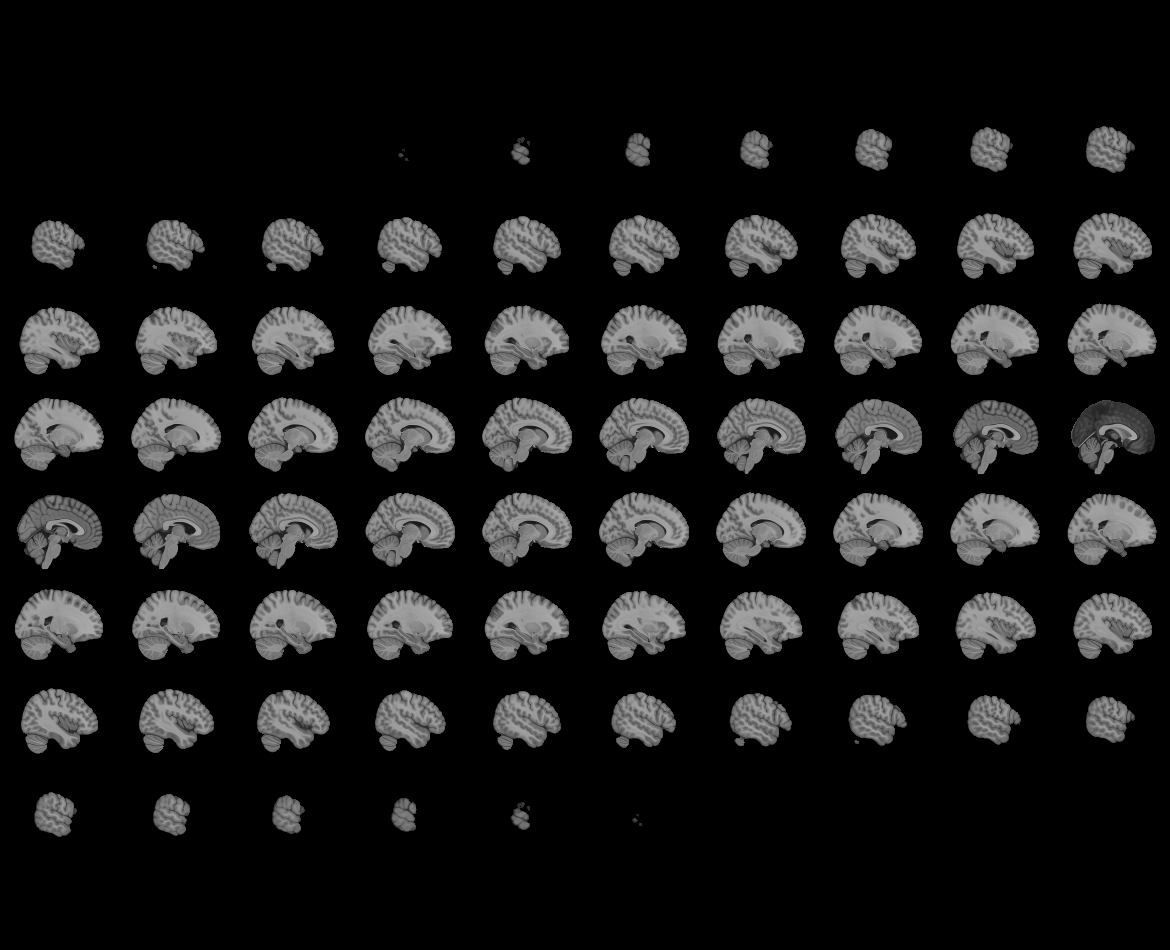
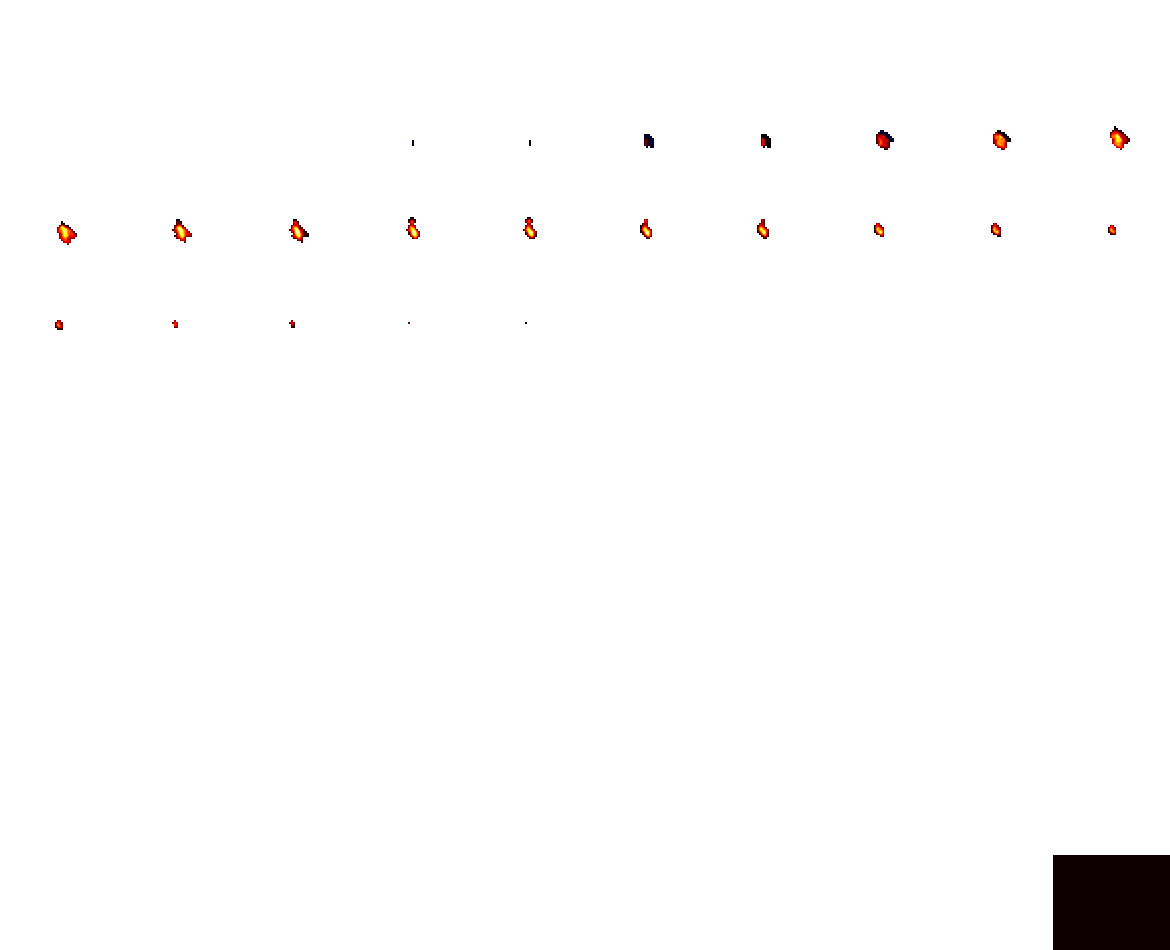

In [45]:
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

mask = np.zeros(39)
mask[0]=1
atlas_img5 = atlas_masker.fit_transform(fmri_filepath, confounds=None)
atlas_img5 = atlas_masker.inverse_transform(mask)

plotting.view_img(atlas_img5)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(


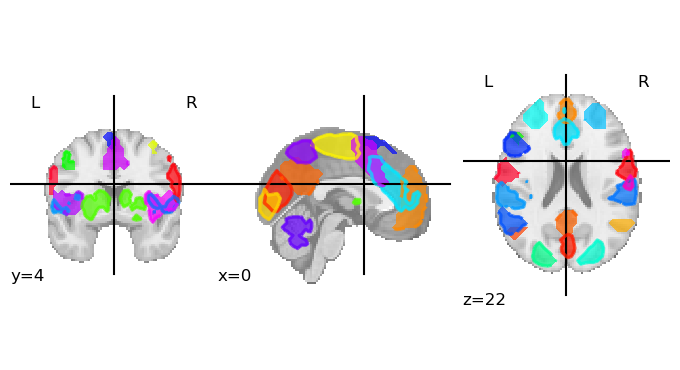

In [42]:
plotting.plot_prob_atlas(atlas_filepath, view_type='filled_contours')

## 3. Seed-based connectivity

* Using the information provided in [this nilearn tutorial](https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html), plot the seed-to-voxel correlation map of our fmri_img for the seed of coordinates (-16, -74, 7) and with a sphere mask of radius of size 10. 

In [ ]:
vis_coords = [(-16, -74, 7)]